In [56]:
import sys
sys.path.append("../")
import numpy as np
from sanchez_ansatz import SanchezAnsatz
from qiskit_aer import Aer
from experiments import get_state
from experiments.util import get_state_vector
from experiments.densities import get_probability_freqs
from experiments import ExperimentModule
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA, COBYLA
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [57]:
## Defining state

num_qubits = 8
state_type = "normal"
#state_params = { "s": 1, "loc": 0.1 , "scale": 0.3, "x_points": np.array([0., 1.]) }
state_params = { "loc": 0.5 , "scale": 0.3, "x_points": np.array([0., 1.]) }


x_points = np.linspace(state_params["x_points"][0], state_params["x_points"][1], 2**num_qubits)

target_state =  get_state(num_qubits=num_qubits, state_type=state_type, state_params=state_params)

eps = 0.01
#computed_eta = 2/state_params["scale"]**2
computed_eta = 4 * np.pi

learning_rate = 1.5
perturbation = 0.9

use_entanglement=False
entanglement_type = "full"

In [58]:
sanchez_ansatz_original = SanchezAnsatz(target_state, eps=eps, eta=computed_eta, use_entanglement=use_entanglement, entanglement_type=entanglement_type) #eta=computed_eta
init_params = sanchez_ansatz_original.init_params

t_sa_o = transpile(sanchez_ansatz_original, basis_gates=["cx", "u"])

em = ExperimentModule(
    t_sa_o,
    SPSA(maxiter=3000, learning_rate=learning_rate, perturbation=perturbation),
    target_state=target_state,
    init_params=init_params,
    device="GPU"
)
result_spsa_original = em.minimize()

em2 = ExperimentModule(
    t_sa_o,
    COBYLA(maxiter=3000, tol=1e-9),
    target_state=target_state,
    init_params=init_params,
    device="GPU"
)
result_cobyla_original = em2.minimize()

In [59]:
sanchez_ansatz_modified = SanchezAnsatz(target_state, eps=eps, eta=computed_eta, build_modified=True, use_entanglement=use_entanglement, entanglement_type=entanglement_type) #eta=computed_eta
init_params = sanchez_ansatz_modified.init_params

t_sa_m = transpile(sanchez_ansatz_modified, basis_gates=["cx", "u"])

em = ExperimentModule(
    t_sa_m,
    SPSA(maxiter=3000, learning_rate=learning_rate, perturbation=perturbation),
    target_state=target_state,
    init_params=init_params,
    device="GPU"
)
result_spsa_modified = em.minimize()

em2 = ExperimentModule(
    t_sa_m,
    COBYLA(maxiter=3000, tol=1e-9),
    target_state=target_state,
    init_params=init_params,
    device="GPU"
)
result_cobyla_modified = em2.minimize()

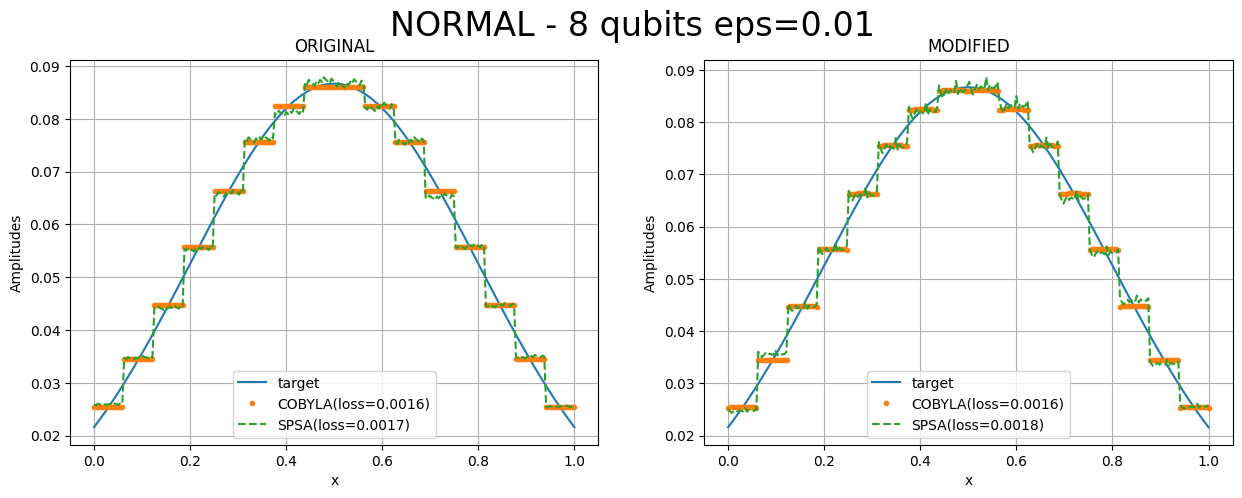

In [60]:
circ_spsa_original = t_sa_o.assign_parameters(result_spsa_original.x)
circ_cobyla_original = t_sa_o.assign_parameters(result_cobyla_original.x)

output_spsa_original = get_state_vector(circ_spsa_original)
output_cobyla_original = get_state_vector(circ_cobyla_original)


circ_spsa_modified = t_sa_m.assign_parameters(result_spsa_modified.x)
circ_cobyla_modified = t_sa_m.assign_parameters(result_cobyla_modified.x)

output_spsa_modified = get_state_vector(circ_spsa_modified)
output_cobyla_modified = get_state_vector(circ_cobyla_modified)


F_spsa_original = 1 - np.abs(target_state @ output_spsa_original)**2
F_cobyla_original = 1 - np.abs(target_state @ output_cobyla_original)**2

F_spsa_modified = 1 - np.abs(target_state @ output_spsa_modified)**2
F_cobyla_modified =1 - np.abs(target_state @ output_cobyla_modified)**2

x = np.linspace(0, 1, 2**num_qubits)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f"{state_type.upper()} - {num_qubits} qubits eps={eps}", fontsize=24)
axes[0].set_title("ORIGINAL")
axes[0].plot(x, target_state, label="target")
axes[0].plot(x, output_cobyla_original, '.', label=f"COBYLA(loss={np.round(F_cobyla_original, 4)})")
axes[0].plot(x, output_spsa_original, '--', label=f"SPSA(loss={np.round(F_spsa_original, 4)})")
axes[0].legend(loc="best")
axes[0].set_ylabel("Amplitudes")
axes[0].set_xlabel("x")
axes[0].grid()

axes[1].set_title("MODIFIED")
axes[1].plot(x, target_state, label="target")
axes[1].plot(x, output_cobyla_modified, '.', label=f"COBYLA(loss={np.round(F_cobyla_modified, 4)})")
axes[1].plot(x, output_spsa_modified, '--', label=f"SPSA(loss={np.round(F_spsa_modified, 4)})")
axes[1].legend(loc="best")
axes[1].set_ylabel("Amplitudes")
axes[1].set_xlabel("x")
axes[1].grid()

plt.show()